In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 
#프로그레스바가 나타나지 않습니다.


(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)



Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2021-12-21 02:24:35.129971: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-21 02:24:35.130092: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [4]:
#노멀라이즈를 통해 로컬 옵티마의 깊이를 줄게여서  빨리빠져 나오게 함
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    image = (image / 255.0)
    return  image, label

In [5]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

2021-12-21 02:24:35.236610: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-21 02:24:35.236793: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


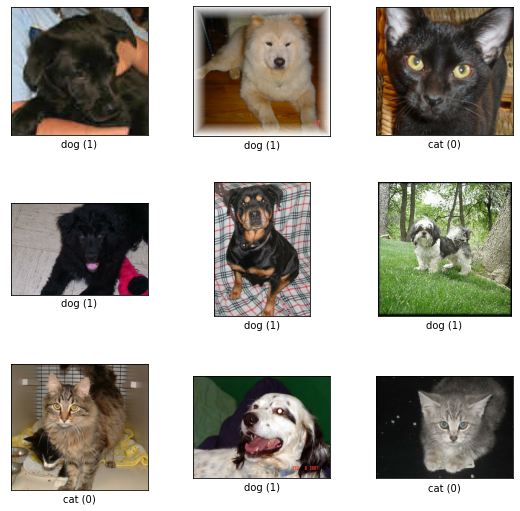

In [6]:
fig = tfds.show_examples(ds_train, ds_info)

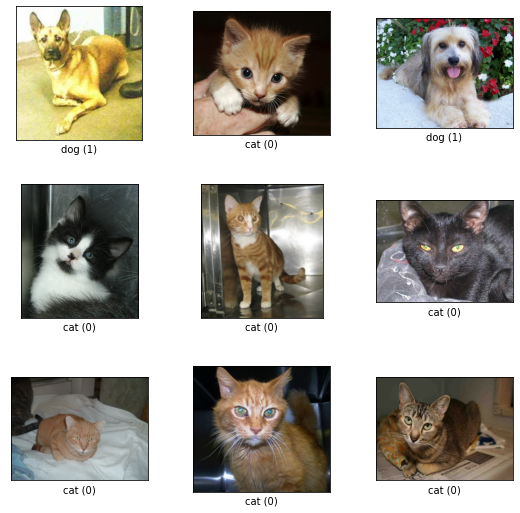

In [7]:
fig = tfds.show_examples(ds_test, ds_info)

(120, 160, 3)
0
(500, 306, 3)
1
(500, 388, 3)
0


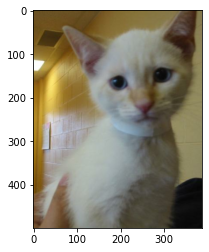

In [8]:
for data in ds_train.take(3):
    plt.imshow(data['image'])
    print(data['image'].shape)
    print(data['label'].numpy())

![resnet](https://d3s0tskafalll9.cloudfront.net/media/images/GC-1-P-table1.max-800x600.png)

In [9]:
#채널사이즈는 매개변수 입력하고 = 지정연산자로 넣는다. 블록반복수 지정.


# function for building resnet Block
# blocknum은 레이어의 이름
# input_layer 요약 출력을 위해서사용

def build_resnet34_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                    _kernal_size = 3,
                    _fix = True
                   ):
    # 입력 레이어
    x = input_layer
    shortcut_layer = input_layer

    is_First = True
    # CNN 레이어 커널 3by3
    # x = func()(x) 구조 레이어 변수에 계속 누적된다.
    
    for cnn_num in range(num_cnn):
        
        _stride = (1,1)
        if _fix:
            if not  is_First:
                _stride = (1,1)
            elif is_First:
                _stride = (2,2)

        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(_kernal_size,_kernal_size),
            kernel_initializer='he_normal',
            strides=_stride,

            padding='same',
            name=f'block{block_num}_conv{cnn_num * 2}',
            use_bias=False #배치노말에 이미 편향 들
        )(x)
        
        x = keras.layers.BatchNormalization(
        )(x)
        x = keras.layers.Activation('relu'
        )(x)
        
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(_kernal_size,_kernal_size),
            kernel_initializer='he_normal',
            strides=1,
            padding='same',
            name=f'block{block_num}_conv{cnn_num * 2 + 1}',
            use_bias=False #배치노말에 이미 편향 들어감
        )(x)
        
        x = keras.layers.BatchNormalization(
        )(x)


        if not  is_First:
            shortcut_layer = keras.layers.BatchNormalization(
            )(shortcut_layer)
            x = keras.layers.Add()([x,shortcut_layer])

        x = keras.layers.Activation('relu'
        )(x)

        shortcut_layer = x
        is_First = False


        
  

    # Max Pooling 레이어
    # 2by2 stri 2
    # x = keras.layers.MaxPooling2D(
    #     pool_size=(2, 2),
    #     strides=2,
    #     name=f'block{block_num}_pooling'
    # )(x)
    #레이를를 반환
    return x

In [10]:
def build_resnet50_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                    _kernal_size = 3,
                    _fix = True
                   ):
    # 입력 레이어
    x = input_layer
    shortcut_layer = input_layer

    is_First = True
    # CNN 레이어 커널 3by3
    # x = func()(x) 구조 레이어 변수에 계속 누적된다.
    
    for cnn_num in range(num_cnn):
        
        _stride = (1,1)
        if _fix:
            if not  is_First:
                _stride = (1,1)
            elif is_First:
                _stride = (2,2)

        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            kernel_initializer='he_normal',
            strides=_stride,

            padding='same',
            name=f'block{block_num}_conv{cnn_num * 3}',
            use_bias=False #배치노말에 이미 편향 들
        )(x)
        
        x = keras.layers.BatchNormalization(
        )(x)
        x = keras.layers.Activation('relu'
        )(x)


        x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        kernel_initializer='he_normal',
        strides=_stride,

        padding='same',
        name=f'block{block_num}_conv{cnn_num * 3 +1}',
        use_bias=False #배치노말에 이미 편향 들
        )(x)
        
        x = keras.layers.BatchNormalization(
        )(x)
        x = keras.layers.Activation('relu'
        )(x)
        
        x = keras.layers.Conv2D(
            filters=channel*4,
            kernel_size=(1,1),
            kernel_initializer='he_normal',
            strides=1,
            padding='same',
            name=f'block{block_num}_conv{cnn_num * 3 + 2}',
            use_bias=False #배치노말에 이미 편향 들어감
        )(x)
        
        x = keras.layers.BatchNormalization(
        )(x)


        if not  is_First:
            shortcut_layer = keras.layers.BatchNormalization(
            )(shortcut_layer)
            x = keras.layers.Add()([x,shortcut_layer])

        x = keras.layers.Activation('relu'
        )(x)

        shortcut_layer = x
        is_First = False


        
  

    # Max Pooling 레이어
    # 2by2 stri 2
    # x = keras.layers.MaxPooling2D(
    #     pool_size=(2, 2),
    #     strides=2,
    #     name=f'block{block_num}_pooling'
    # )(x)
    #레이를를 반환
    return x

In [11]:
def build_resnet34_init(input_layer):

    x = input_layer
    x = keras.layers.Conv2D(
            filters=64,
            kernel_size=(7,7),
            kernel_initializer='he_normal',
            padding='same',
            name=f'block1_conv1',
            use_bias=False, #배치노말에 이미 편향 들
            strides=(2, 2)
        )(x)

    x = keras.layers.BatchNormalization(
    )(x)

    x = keras.layers.Activation('relu'
    )(x)
    #0 이하는 활성 안한다 = 필요없다!
    # 큰값은 더크게 나옴 큰특징을 원한다.

    #
    x = keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2),padding='same')(x)

    return x
    

In [12]:
def build_resnet34_finish(input_layer):
    x = input_layer

    x = keras.layers.AveragePooling2D(padding='same')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(2, activation='softmax')(x)
    #x = keras.layers.Activation('softmax')(x)
    return x



In [13]:
#%debug (build_resnet34_block)

In [14]:

def build_resnet(input_shape=(224,224,3),is_50 = False):

    resnet_input_layer = keras.layers.Input(input_shape)   # 입력 레이어 생성

    resnet_block_output = build_resnet34_init(resnet_input_layer) 

    if is_50:
        resnet_block_output = build_resnet50_block(resnet_block_output,block_num=2,_fix = False)
        resnet_block_output = build_resnet50_block(resnet_block_output,block_num=3,channel=128,num_cnn=4)
        resnet_block_output = build_resnet50_block(resnet_block_output,block_num=4,channel=256,num_cnn=6)
        resnet_block_output = build_resnet50_block(resnet_block_output,block_num=5,channel=512,num_cnn=3)
  
    else:
        resnet_block_output = build_resnet34_block(resnet_block_output,block_num=2,_fix = False)
        resnet_block_output = build_resnet34_block(resnet_block_output,block_num=3,channel=128,num_cnn=4)
        resnet_block_output = build_resnet34_block(resnet_block_output,block_num=4,channel=256,num_cnn=6)
        resnet_block_output = build_resnet34_block(resnet_block_output,block_num=5,channel=512,num_cnn=3)
    
    resnet_block_output = build_resnet34_finish(resnet_block_output)

    model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  

    model.summary()
    return model

resnet34 = build_resnet()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
resnet50 = build_resnet(is_50= True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 112, 112, 64) 9408        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 112, 112, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 112, 112, 64) 0           batch_normalization_45[0][0]     
____________________________________________________________________________________________

In [16]:
BATCH_SIZE = 128
EPOCH = 5

resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)



/Users/woogyuchoi/miniforge3/envs/tf2/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


TypeError: in user code:


    TypeError: tf__normalize_and_resize_img() missing 1 required positional argument: 'label'


In [ ]:
history_34 = resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

ValueError: Unknown split "test". Should be one of ['train'].

In [ ]:
history_50 = resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['34', '50'], loc='upper left')
plt.show()

plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['34', '50'], loc='upper left')
plt.show()
